In [1]:
import numpy as np
from matplotlib import pyplot as plt
import scipy as sp
from scipy.fftpack import idct


Variable initialization

In [2]:
N = 32 # signal dimension
M = 32 # number of atoms in the span (for basis M = N)

C = np.zeros((N, M)) # matrix containing the standard basis (a kronecker delta in each column)
D = np.zeros((N, M)) # matrix containing the DCT basis (a DCT function in each column)


Generate the 1D-DCT basis

Text(0.5, 1.0, 'DCT basis')

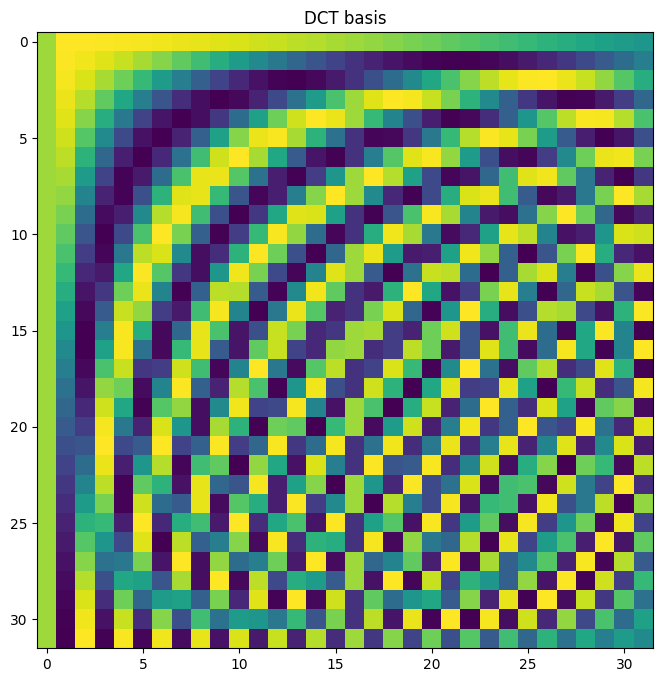

In [3]:
for i in range(M):
    a = np.zeros(M)
    a[i] = 1
    D[:, i] = sp.fftpack.idct(a, norm='ortho')

plt.figure(figsize=(8,8))
plt.imshow(D)
plt.title('DCT basis')

# Sparsity w.r.t orthonormal dictionary D

In this section you will perform denoising of a signal that is *sparse* w.r.t. the orthornormal dictionary $D\in\mathbb{R}^{N\times N}$, i.e., the 1D-DCT dictionary.

At first, generate a vector $x_{orig}\in\mathbb{R}^N$ that is $L$-sparse, i.e. $\|x_{orig}\|_0 = L$. Use this coefficient vector $x_{orig}$, generate a noise-free signal $y\in\mathbb{R}^N$ as $y=Dx_{orig}$, and add some Gaussian noise to obtain $s = y + \eta$.

Perform the DCT denoising on the noisy signal $s$ to recover $\hat y$. Use the Hard Thresholding operator that keeps only the largest $L$ coefficients and evaluate the denoising performance


Set the sparsity level $L$

In [4]:
L = 3

Randomly define the coefficients of a sparse representation $x$ (make sure the nonzero coefficients are sufficiently large)

In [5]:
def generate_sparse_representation(L, M):
  indexes = np.random.choice(M, L, replace=False)
  coefficients = 5*np.random.rand(L)
  x0 = np.zeros(M)
  x0[indexes] = coefficients
  return x0

In [6]:
x_orig = generate_sparse_representation(L, N)

In [7]:
print(x_orig)

[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         4.79194299 0.
 0.         2.96791301 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         1.76948636 0.         0.         0.         0.
 0.         0.        ]


Text(0.5, 1.0, 'Sparse representation')

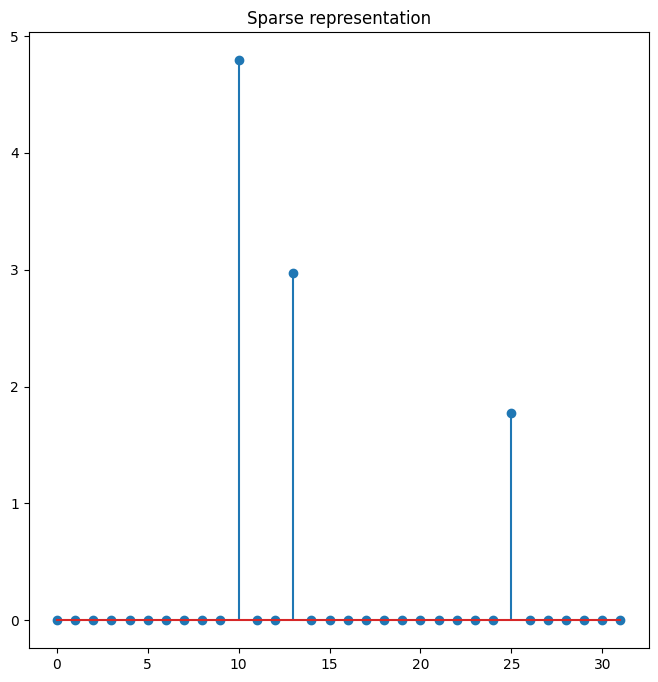

In [8]:
# Plot x0
plt.figure(figsize=(8,8))
plt.stem(x_orig)
plt.title('Sparse representation')

Synthetize the corresponding signal in the signal domain and add noise


In [9]:
y = np.dot(D, x_orig)
sigma_noise = 0.3
s = y + sigma_noise*np.random.normal(size=y.shape)

Plot the sparse signal

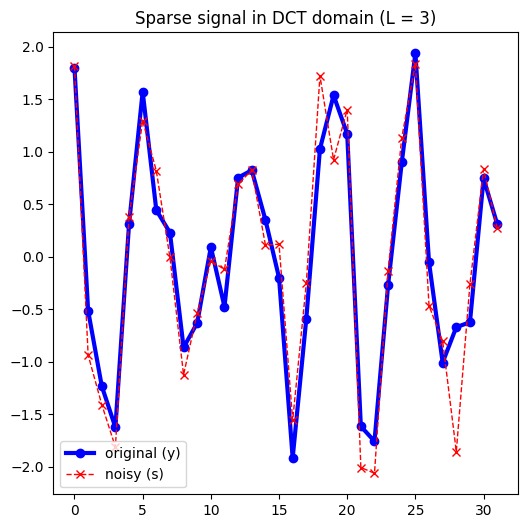

In [10]:
LN_WDT = 2
MRK_SZ = 10

plt.figure(figsize=(6,6))
plt.plot(y, 'b-o', linewidth=LN_WDT+1)
plt.plot(s, 'r--x', linewidth=LN_WDT-1)
plt.title(f'Sparse signal in DCT domain (L = {L:.0f})')
plt.legend(['original (y)', 'noisy (s)'])


### Implement the DCT denoising

This is expected to be very effective on $s$!

**Analysis**: compute the coefficients w.r.t. $D$

In [11]:
x = np.dot(D.T, s)

**Hard Thresholding**: keep only the $L$ largest coefficients (absolute value)

In [12]:
def hard_thresholding(coefficients_x, L):
  # get the indexes of the L largest coefficients
  top_L_indexes = np.argsort(np.abs(coefficients_x))[-L:]
  # set all coefficients to zero
  coefficients_x[~np.isin(np.arange(len(coefficients_x)), top_L_indexes)] = 0
  return coefficients_x

In [13]:
x_hat = hard_thresholding(x, L)

**Synthesis**: invert the transform

In [14]:
s_hat = np.dot(D, x_hat)

Plot the results:
- are the denoising performance good?
- are the original coefficients $x_{orig}$ recovered by $\hat x$?

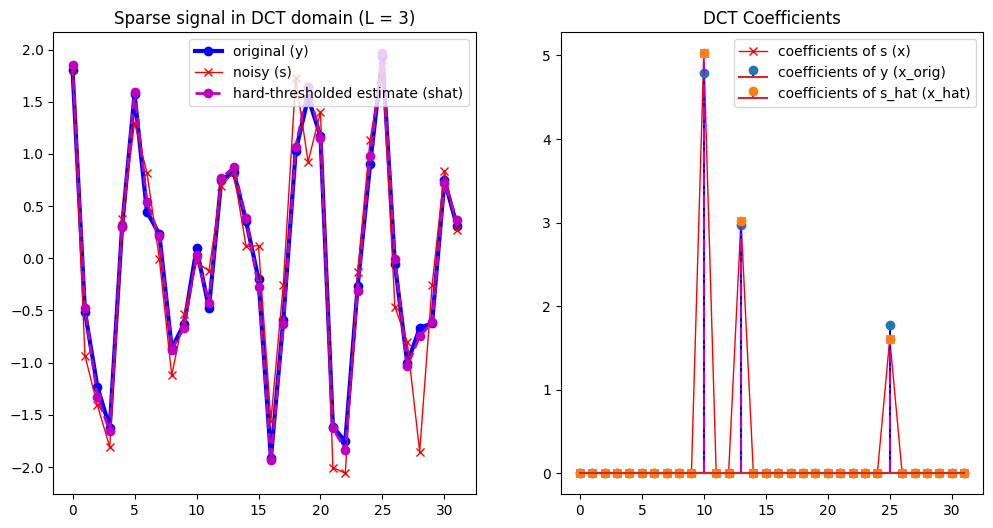

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(12,6))
ax[0].plot(y, 'b-o', linewidth=LN_WDT+1)
ax[0].plot(s, 'r-x', linewidth=LN_WDT-1)
ax[0].plot(s_hat, 'm--o', linewidth=LN_WDT)
ax[0].set_title(f'Sparse signal in DCT domain (L = {L:.0f})')
ax[0].legend(['original (y)', 'noisy (s)', 'hard-thresholded estimate (shat)'])



ax[1].plot(x, 'r-x', linewidth=LN_WDT-1)
ax[1].stem(x_orig, linefmt='b-', markerfmt='C0o')
ax[1].stem(x_hat, linefmt='m-.', markerfmt='C1o')
ax[1].set_title('DCT Coefficients')
ax[1].legend(['coefficients of s (x)', 'coefficients of y (x_orig)', 'coefficients of s_hat (x_hat)'])


# Sparsity w.r.t redoundant dictionary

In this section you will perform the same denoising as in the previous section with the only difference that the signal $s = y + \eta$ that you will generate is sparse w.r.t. a redoundant dictionary $A=[C, D] \in\mathbb{R}^{M \times N}$, where $C\in\mathbb{M\times M}$ is the matrix representity the canonical basis, and $D\in\mathbb{M\times M}$ is the usual 1D-DCT matrix. Therefore $A$ is a rectangular matrix, since $M < N$.

To generate signals that are sparse w.r.t. $A=[C, D]$, at first generate a signal $y$ that is $L-1$ sparse w.r.t. $D$ as you have done in the previous section. Then, add a spike to $y$ that is sparse w.r.t. $A$. Bear in mind that the spike is to be considered a signal to be reconstructed, rather than noise.

Generate the standard orthonormal basis

Text(0.5, 1.0, 'Canonical basis dimension n = 32')

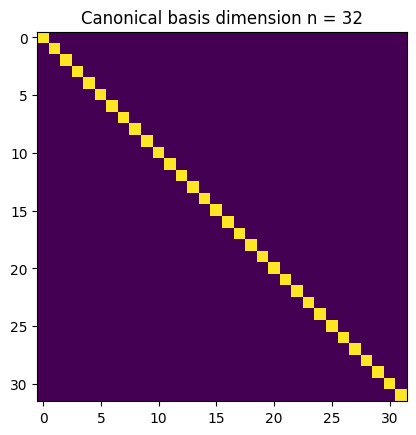

In [16]:
for i in range(M):
    C[i, i] = 1

plt.figure(5)
plt.imshow(C)
plt.title(f'Canonical basis dimension n = {M}')




Generate a signal that is sparse w.r.t. D

In [17]:
x_orig = generate_sparse_representation(L, N)
y = np.dot(D, x_orig)

Randomly place a spike in the first 20 samples of $y$


In [18]:
# choose spike location
spikeLocation = np.random.randint(20)
# modify the signal intensity at spikeLocation
# update y
lambda_spike = 5*np.abs(max(y))
y[spikeLocation] = lambda_spike

Add noise to the signal

In [19]:
s = y + np.random.normal(size= y.shape)*sigma_noise

Perform hard thresholding by keeping the largest $L$ coefficients w.r.t. $D$ (not $A$!)

In [20]:
# analysis: compute the coefficients w.r.t. D
x = np.dot(D.T, s)

# keep only the L largest coefficients (absolute value)
x_hat = hard_thresholding(x, L)

# invert the transformation
s_hat = np.dot(D, x_hat)

Plot the results and compare them to the one obtained in the previous section.

Is the signal $s$ denoised properly?

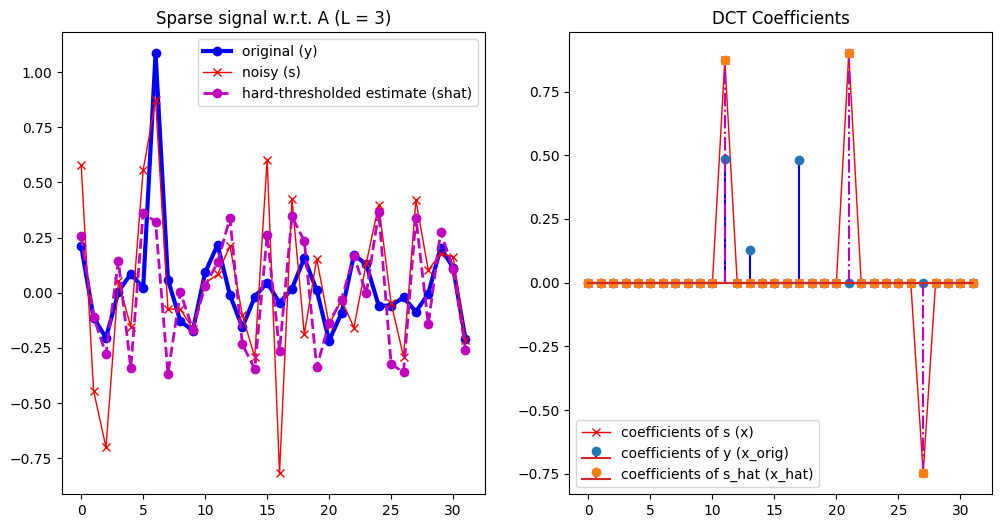

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(12,6))
ax[0].plot(y, 'b-o', linewidth=LN_WDT+1)
ax[0].plot(s, 'r-x', linewidth=LN_WDT-1)
ax[0].plot(s_hat, 'm--o', linewidth=LN_WDT)
ax[0].set_title(f'Sparse signal w.r.t. A (L = {L:.0f})')
ax[0].legend(['original (y)', 'noisy (s)', 'hard-thresholded estimate (shat)'])


ax[1].plot(x, 'r-x', linewidth=LN_WDT-1)
ax[1].stem(x_orig, linefmt='b-', markerfmt='C0o')
ax[1].stem(x_hat, linefmt='m-.', markerfmt='C1o')
ax[1].set_title('DCT Coefficients')
ax[1].legend(['coefficients of s (x)', 'coefficients of y (x_orig)', 'coefficients of s_hat (x_hat)'])

## Tichonov Regularization


Compute the representation w.r.t. $A = [C, D]$ using Tichonov's regularization (try differente value for $\lambda$)

In [22]:
A = np.hstack((C, D))

In [28]:
lmbda = 1
x_hat_tic = np.dot(np.linalg.inv(np.dot(A.T, A) + lmbda*np.eye(2*N)),np.dot(A.T, s))
s_hat_tic = np.dot(A, x_hat_tic)


Text(0.5, 1.0, 'A basis of dimension (32, 64)')

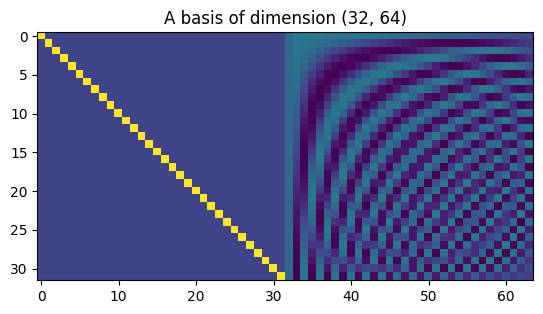

In [25]:
plt.figure(6)
plt.imshow(A)
plt.title(f'A basis of dimension {A.shape}')

Show the results

Text(0.5, 1.0, 'Coefficients w.r.t. A')

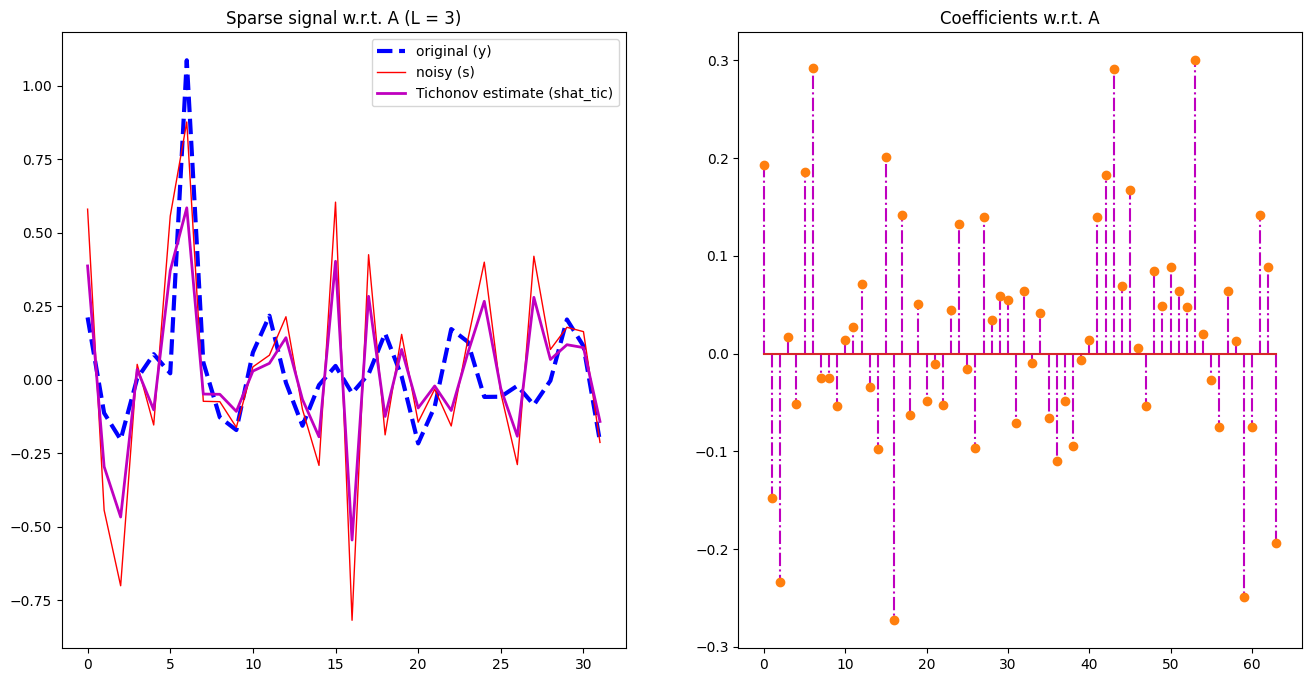

In [29]:
LN_WDT = 2
MRK_SZ = 10

fix, ax = plt.subplots(1, 2, figsize=(16, 8))
ax[0].plot(y, 'b--', linewidth=LN_WDT + 1)
ax[0].plot(s, 'r-', linewidth=LN_WDT - 1)
ax[0].plot(s_hat_tic, 'm-', linewidth=LN_WDT)
ax[0].set_title(f'Sparse signal w.r.t. A (L = {L:.0f})')
ax[0].legend(['original (y)', 'noisy (s)', 'Tichonov estimate (shat_tic)'])

ax[1].stem(x_hat_tic, linefmt='m-.', markerfmt='C1o')
ax[1].set_title('Coefficients w.r.t. A')